We start by adding the necessary folders to the current working path.

In [2]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add LAVD folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/LAVD2D")

Wall time: 0 ns


# Overview

In the following notebook we evaluate the Lagrangian Averaged Vorticity Deviation (LAVD) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Lagrangian Averaged Vorticity Deviation (LAVD):

    * Compute trajectories launched from a regular meshgrid.
    <br />
    
    * Compute the vorticity along particle trajectories 
    <br />
    \begin{equation}
    \mathbf{\omega}(\mathbf{x},t) = \nabla \times \mathbf{v}(\mathbf{x},t) 
    \end{equation}
    <br />
    * Compute LAVD as:
    <br />
    \begin{equation}
    \mathrm{LAVD}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i=0}^{N} | \mathbf{\omega}(\mathbf{x}(t_i), t) - \overline{\mathbf{\omega}(t)} |,
    \end{equation} where $ \overline{\mathbf{\omega}(t)} $ is the spatially averaged vorticity. <br />
 <br />
 
6. Extract vortex boundaries from LAVD using the algorithm proposed in [1]

 <br />
7. References

# Import data

In [3]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

Wall time: 113 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [4]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 5 # int >= 1

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

Wall time: 998 µs


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [5]:
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 25 # float

# Time step-size (in days)
dt = 0.1*np.sign(tN-t0) # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5 # float
xmax = 1 # float
ymin = -32 # float
ymax = -24 # float

# Make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# Spacing of meshgrid (in degrees)
dx = 0.05 # float
dy = 0.05 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # float between [1/5, 1/10]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

Wall time: 0 ns


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic". 

In [6]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

Wall time: 189 ms


# Lagrangian Averaged Vorticity Deviation (LAVD)

In [7]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import function to compute LAVD
from ipynb.fs.defs.LAVD import _LAVD

# Import function to check particle location
from ipynb.fs.defs.check_location import check_location

# Import package for parallel computing
from joblib import Parallel, delayed

# Vectorize initial conditions
x0 = X_domain.ravel() # array (Ny*Nx, )
y0 = Y_domain.ravel() # array (Ny*Nx, )

# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # array (Ny*Nx, )
y0_batch = list(split(y0, Ncores)) # array (Ny*Nx, )

def parallel_Omega(x0_batch, y0_batch):
    
    # Define array containing vorticity along a trajectory
    omega = np.zeros((X_domain.shape[0]*X_domain.shape[1], len(time))) # array (Ny*Nx, Nt)
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # array (Nt, 2, Nx*Ny)
    
    # Check if initial position is inside out outside flow domain.
    for i in range(Fmap.shape[2]):
        
        if check_location(X, Y, defined_domain, np.array([Fmap[0,0,i], Fmap[0,1,i]]))[0] != "IN": # bool
            
            Fmap[:,:,i] = np.nan
    
    omega = np.zeros((Fmap.shape[0], Fmap.shape[2])) # array (Nt, Ny*Nx)
    
    # Iterate over time
    for t in range(Fmap.shape[0]):
        
        # Compute gradient of velocity field
        grad_vel = gradient_velocity(time[t], Fmap[t,:,:], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
        # Compute spin tensor
        W = .5*(grad_vel-grad_vel.transpose(1,0,2))  # array (2, 2, Ny*Nx)
                
        omega[t,:] = 2*W[0,1,:]

    return omega

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Omega)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract Omega from results of parallel computing
Omega = results[0]

for res in results[1:]:
    Omega = np.append(Omega, res, axis = 1)

# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
Omega = Omega.reshape((Omega.shape[0], X_domain.shape[0], X_domain.shape[1])) # array (Nt, Ny, Nx)

# Compute LAVD from vorticity along trajectories
LAVD = _LAVD(Omega, lenT)  # array (Ny, Nx)

Wall time: 17.1 s


# Vortex boundaries from LAVD

The vortex boundaries are extracted following the algorithm proposed in [1].

In [13]:
# Import function to compute outermost vortex boundary according to [1]
from ipynb.fs.defs.find_outermost_contour import find_outermost_contour

# Minimum distance between local maxima in the LAVD field
distance = 0.5 # float >=0

# Resolution of LAVD field when extracting contours
n = 250 # int

# Convexity deficiency
c_d = 10**(-6) # float > 0

# Reject local maxima below this threshold
loc_threshold = 5 # float >= 0

# Minimum length of vortex boundary
l_min = 0.5 # float >= 0

# find outermost contour satisfying the specifi conditions = estimated vortex boundary.
vortex = find_outermost_contour(X_domain, Y_domain, LAVD, distance, n, c_d, l_min, loc_threshold, Ncores) # list containing vortex boundaries

  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:    0.4s finished


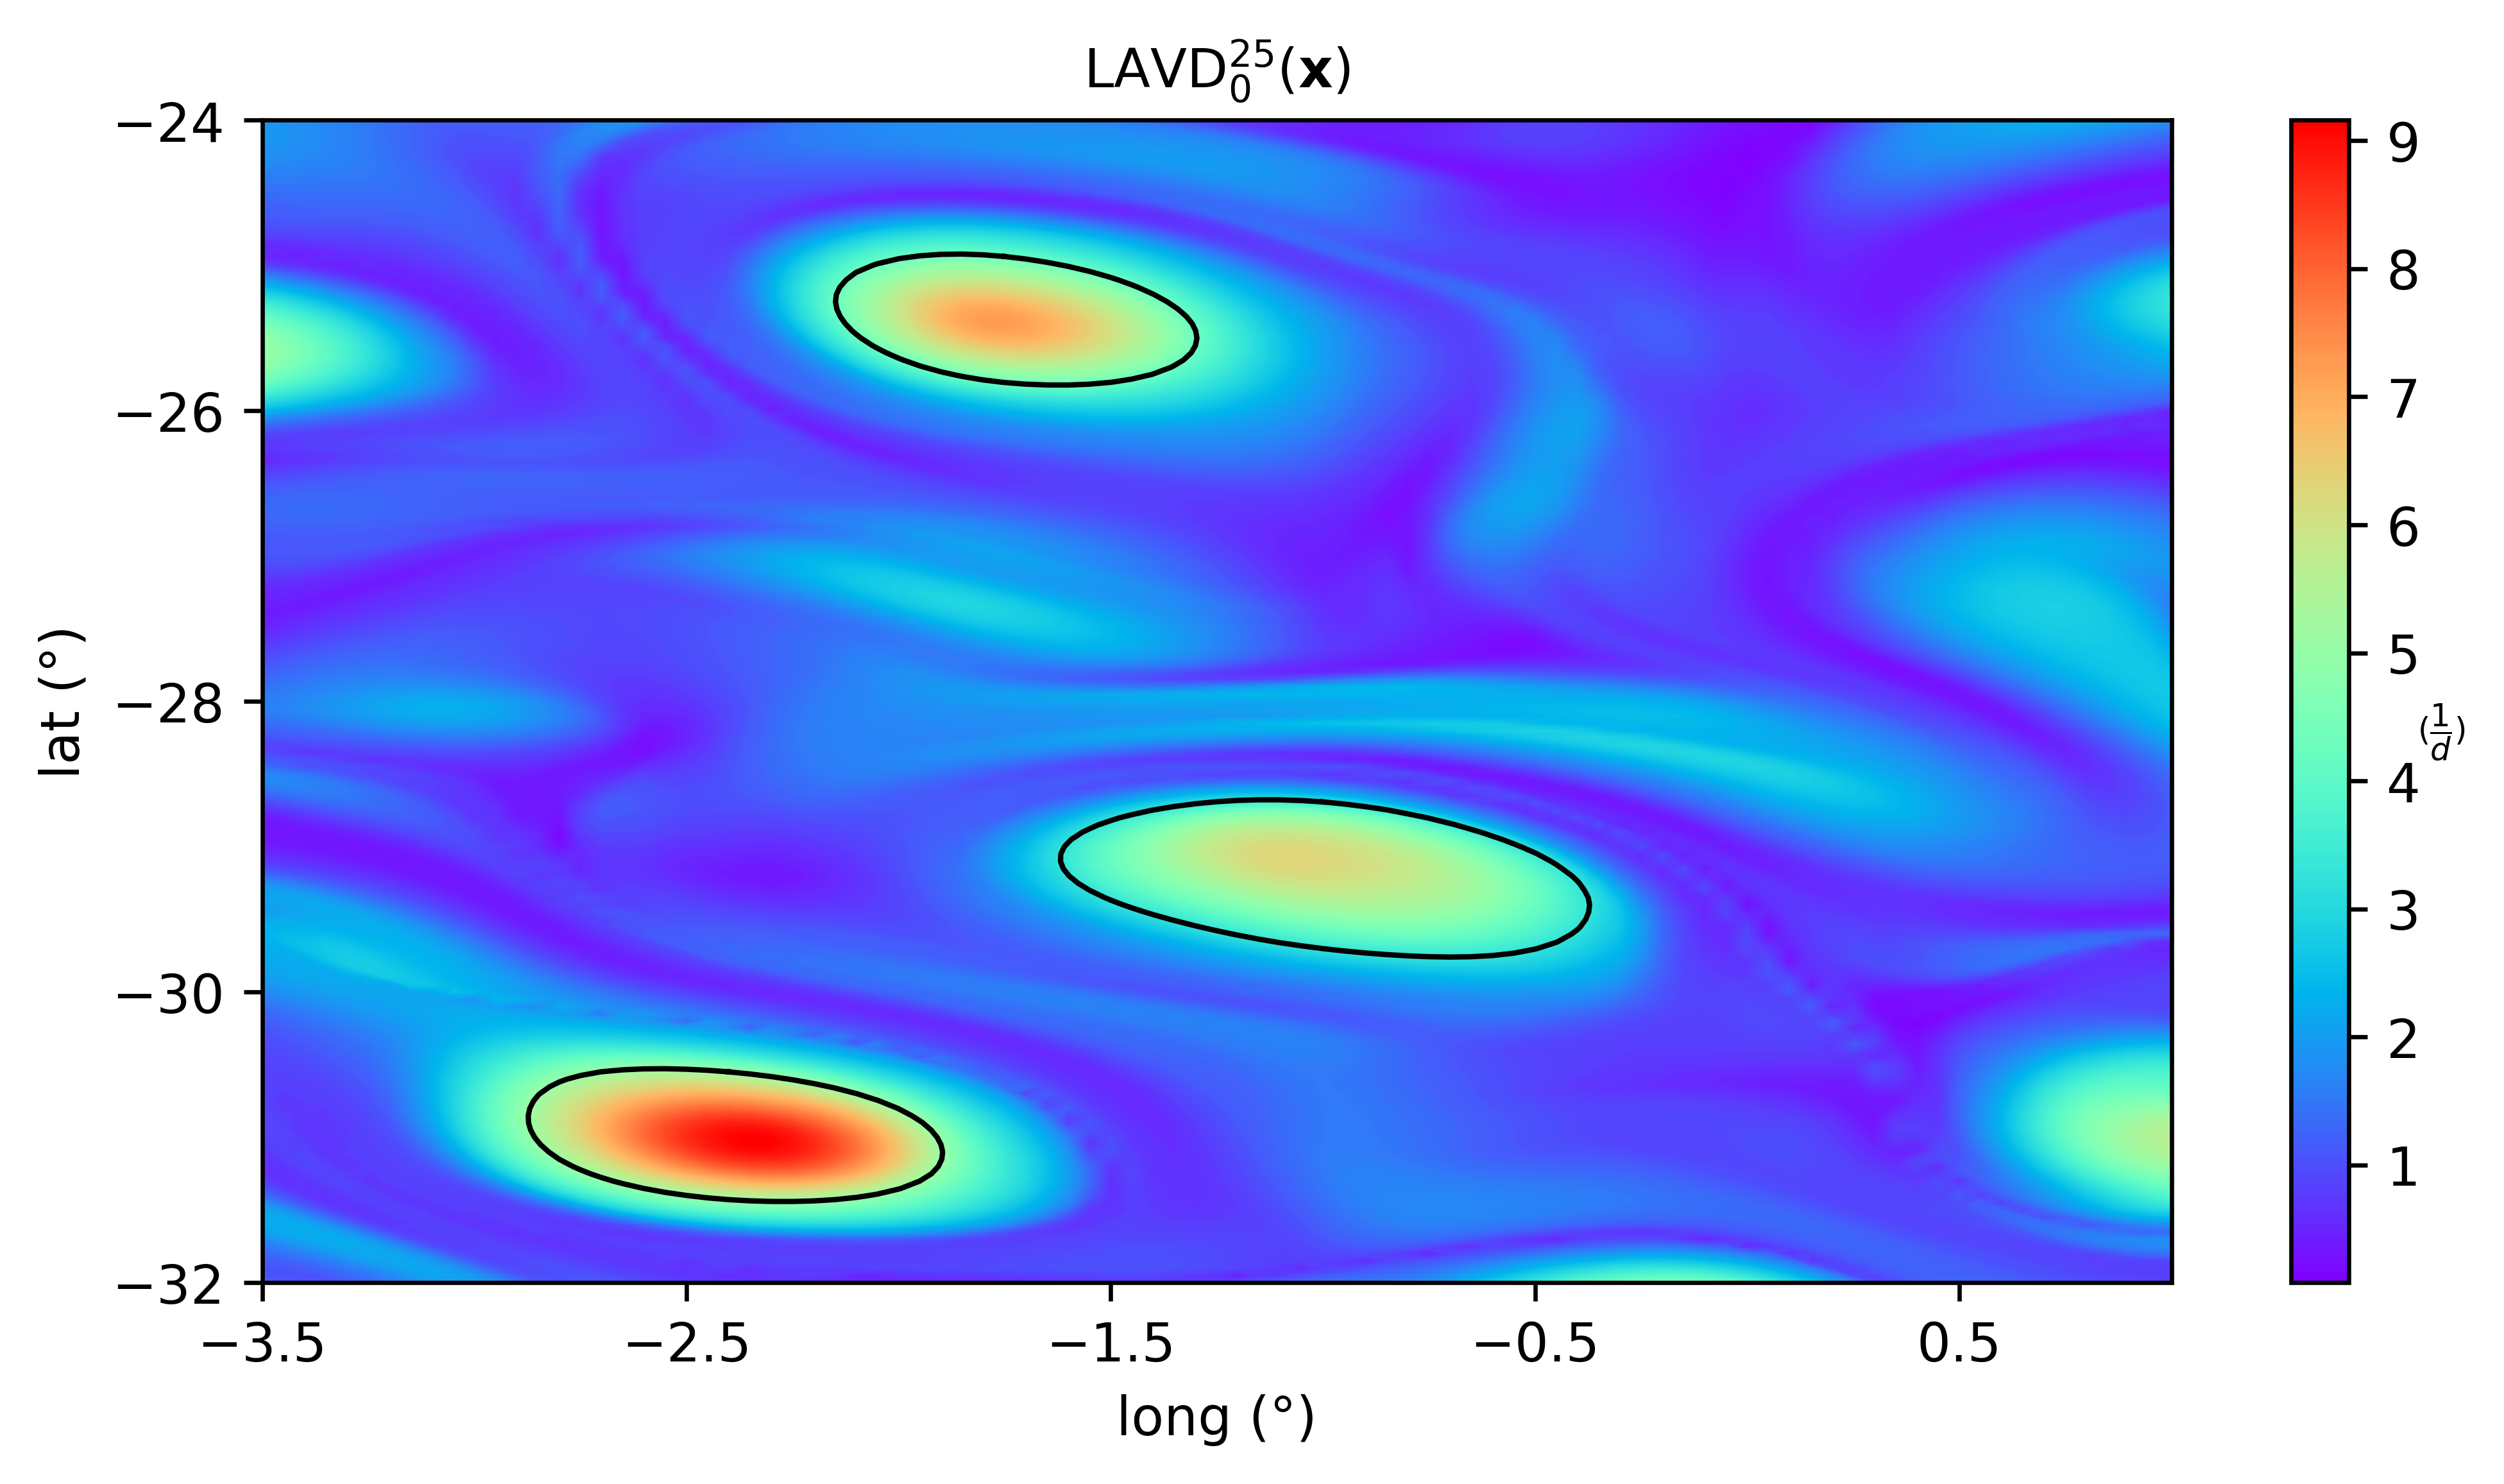

In [14]:
############################################ PLOT RESULTS ############################################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of LAVD over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, LAVD, cmap = "rainbow", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# plot vortex boundaries
for v in vortex:
    ax.plot(v[0], v[1], c = "k", linestyle = "solid", linewidth = 1)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax.set_yticks(np.arange(ymin, ymax+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 10, 1))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0,fontsize = 6)

# Title
ax.set_title(r'$ \mathrm{LAVD}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

Vortical flow regions are identified as closed level curves around local extrema of the $ \mathrm{LAVD} $ satisfying specific conditions. The closed black lines indicate the identified vortex boundaries. The elliptic LCSs are clearly visible as concentric closed contours of the $ \mathrm{LAVD} $ at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{LAVD} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [TRA](../../TRA2D/Main/TRAAgulhas.ipynb), the [EllipticLCS](../../EllipticLCS/Main/EllipticLCSAgulhas.ipynb) or the [PRA](../../PRA2D/Main/PRAAgulhas.ipynb).

# References

[1] Haller, G., Hadjighasem, A., Farazmand, M., & Huhn, F. (2016). Defining coherent vortices objectively from the vorticity. Journal of Fluid Mechanics, 795, 136-173.

[2] Notebook 5.2.8. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.